### Treinamento do Modelo Machine Learning

In [25]:
%pip install pandas scikit-learn xgboost joblib


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Importações de Bibliotecas

In [102]:
# Data load and processing
import pandas as pd
import numpy as np
from typing import List, Tuple
import boto3
from io import StringIO
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

In [101]:
## Pre-Processing and evaluation
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score
from yellowbrick.features import FeatureImportances

In [55]:
# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import dump

#### Instruções

1. Renomear o arquivo .env_exemplo para somente .env
2. Adicionar popular as variaveis conforme o padrão de nomenclatura que voce utilizar

### Reading the Data

In [56]:
load_dotenv()
def read_from_s3(bucket_name:str):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    response = []
    for obj in bucket.objects.all():
        body = obj.get()['Body'].read()
        s=str(body,'utf-8')
        data = StringIO(s)
        response.append(pd.read_csv(data, index_col=0))
    return response

In [115]:
bucket_name = os.environ['BUCKET_NAME']
csv_file_name = os.environ['CSV_FILE_NAME']
bucket_layer = os.environ['BUCKET_LAYER']
object_name = f'{bucket_layer}/{csv_file_name}'
data = read_from_s3(bucket_name)[0]
data.head()

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,close_ratio_2,...,trend_30,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365,fng_index,fng_class,target
2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,7620590080,3.066667,-0.307224,0.541296,11489.700195,1.000000,...,NaN,1.000000,3.066667,NaN,1.000000,3.066667,NaN,47,Neutral,1
2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,6690570240,3.066667,-0.307224,0.541296,11512.599609,1.017864,...,1.00,1.017864,3.066667,1.00,1.017864,3.066667,1.00,56,Greed,1
2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,6084149760,2.933333,-0.258349,0.513519,11573.299805,1.000996,...,1.00,1.013174,3.022222,1.00,1.013174,3.022222,1.00,44,Fear,1
2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,6468539904,2.866667,-0.259235,0.496852,10779.900391,1.002629,...,1.00,1.013823,2.983333,1.00,1.013823,2.983333,1.00,55,Greed,0
2018-03-06,11500.099609,11500.099609,10694.299805,10779.900391,6832169984,2.666667,-0.249632,0.474630,9965.570312,0.964506,...,0.75,0.954955,2.920000,0.75,0.954955,2.920000,0.75,59,Greed,0


### Data Pre-Processing

In [116]:
# If working with data, please uncoment this line for safety, this will generate a backup of the dataframe prior to pre-processing
df_backup = data.copy()

In [118]:
def shift_data_up(df:pd.DataFrame, shift_by:int=1)->pd.DataFrame:
    df['edit_count_y'] = df["edit_count"].shift(1)
    df['sentiment_y'] = df["sentiment"].shift(1)
    df['neg_sentiment_y'] = df["neg_sentiment"].shift(1)
    df['fng_index_y'] = df["fng_index"].shift(1)
    return df


In [119]:
new_data = shift_data_up(data)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2379 entries, 2018-03-02 to 2024-09-07
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             2379 non-null   float64
 1   high             2379 non-null   float64
 2   low              2379 non-null   float64
 3   close            2379 non-null   float64
 4   volume           2379 non-null   int64  
 5   edit_count       2379 non-null   float64
 6   sentiment        2379 non-null   float64
 7   neg_sentiment    2379 non-null   float64
 8   tomorrow         2379 non-null   float64
 9   close_ratio_2    2379 non-null   float64
 10  edit_2           2379 non-null   float64
 11  trend_2          2378 non-null   float64
 12  close_ratio_7    2379 non-null   float64
 13  edit_7           2379 non-null   float64
 14  trend_7          2378 non-null   float64
 15  close_ratio_30   2379 non-null   float64
 16  edit_30          2379 non-null   float64
 17  tren

In [120]:
drop_columns = ['edit_count', 
                'sentiment', 
                'neg_sentiment', 
                'fng_index', 
                'fng_class']

new_data.drop(columns=drop_columns, axis=1, inplace=True)
new_data.head()

,open,high,low,close,volume,tomorrow,close_ratio_2,edit_2,trend_2,close_ratio_7,...,edit_60,trend_60,close_ratio_365,edit_365,trend_365,target,edit_count_y,sentiment_y,neg_sentiment_y,fng_index_y
2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,7620590080,11489.700195,1.000000,3.066667,NaN,1.000000,...,3.066667,NaN,1.000000,3.066667,NaN,1,NaN,NaN,NaN,NaN
2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,6690570240,11512.599609,1.017864,3.066667,1.0,1.017864,...,3.066667,1.00,1.017864,3.066667,1.00,1,3.066667,-0.307224,0.541296,47.0
2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,6084149760,11573.299805,1.000996,3.000000,1.0,1.013174,...,3.022222,1.00,1.013174,3.022222,1.00,1,3.066667,-0.307224,0.541296,56.0
2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,6468539904,10779.900391,1.002629,2.900000,1.0,1.013823,...,2.983333,1.00,1.013823,2.983333,1.00,0,2.933333,-0.258349,0.513519,44.0
2018-03-06,11500.099609,11500.099609,10694.299805,10779.900391,6832169984,9965.570312,0.964506,2.766667,0.5,0.954955,...,2.920000,0.75,0.954955,2.920000,0.75,0,2.866667,-0.259235,0.496852,55.0


In [121]:
new_data.dropna(inplace=True)

In [122]:
reorg_columns = ['open', 'high', 'low', 'close', 'volume', 'close_ratio_2',
       'edit_2', 'trend_2', 'close_ratio_7', 'edit_7', 'trend_7',
       'close_ratio_30', 'edit_30', 'trend_30', 'close_ratio_60', 'edit_60',
       'trend_60', 'close_ratio_365', 'edit_365', 'trend_365', 'edit_count_y', 
       'sentiment_y', 'neg_sentiment_y', 'fng_index_y','target']

new_data = new_data[reorg_columns]
new_data.head()

,open,high,low,close,volume,close_ratio_2,edit_2,trend_2,close_ratio_7,edit_7,...,edit_60,trend_60,close_ratio_365,edit_365,trend_365,edit_count_y,sentiment_y,neg_sentiment_y,fng_index_y,target
2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,6690570240,1.017864,3.066667,1.0,1.017864,3.066667,...,3.066667,1.00,1.017864,3.066667,1.00,3.066667,-0.307224,0.541296,47.0,1
2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,6084149760,1.000996,3.000000,1.0,1.013174,3.022222,...,3.022222,1.00,1.013174,3.022222,1.00,3.066667,-0.307224,0.541296,56.0,1
2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,6468539904,1.002629,2.900000,1.0,1.013823,2.983333,...,2.983333,1.00,1.013823,2.983333,1.00,2.933333,-0.258349,0.513519,44.0,0
2018-03-06,11500.099609,11500.099609,10694.299805,10779.900391,6832169984,0.964506,2.766667,0.5,0.954955,2.920000,...,2.920000,0.75,0.954955,2.920000,0.75,2.866667,-0.259235,0.496852,55.0,0
2018-03-07,10803.900391,10929.500000,9692.120117,9965.570312,8797910016,0.960747,2.650000,0.0,0.900402,2.872222,...,2.872222,0.60,0.900402,2.872222,0.60,2.666667,-0.249632,0.474630,59.0,0


In [123]:
# Defining the predictors Columns
predictors: List[str] = ['open', 'high', 'low', 'close', 'volume', 'close_ratio_2',
       'edit_2', 'trend_2', 'close_ratio_7', 'edit_7', 'trend_7',
       'close_ratio_30', 'edit_30', 'trend_30', 'close_ratio_60', 'edit_60',
       'trend_60', 'close_ratio_365', 'edit_365', 'trend_365', 'edit_count_y', 
       'sentiment_y', 'neg_sentiment_y', 'fng_index_y']

map = {'Neutral': 0, 'Greed': 1, 'Fear': -1, 'Extreme Fear': -2, 'Extreme Greed': 2}

std_scaler = StandardScaler()

In [71]:
# #Adjusting fng classification values
# def adjust_df_for_ml(df:pd.DataFrame, map:dict) -> pd.DataFrame:
#     df['fng_class_yest_adjusted'] = df['fng_class_yest'].map(map)
#     df.drop(columns=['fng_class', 'fng_class_yest'], axis=1, inplace=True)
#     return df

# ml_data = adjust_df_for_ml(df=new_data, map=map)
# ml_data.head()

Here we are going to test 3 approaches:

1. without any normalization or scalling
2. applying a normalization
3. applying scalling

In [124]:
#spliting data for gridsearch
train = new_data.iloc[0:2000]
test = new_data.iloc[2000:2378]

## prepare x_train for models
X_train = train[predictors]
X_train_norm = normalize(train[predictors])
X_train_scaled = std_scaler.fit_transform(train[predictors])

## prepate x_test for models
X_test = test[predictors]
X_test_norm = normalize(test[predictors])
X_test_scaled = std_scaler.fit_transform(test[predictors])

## Target
y_train = train['target']
y_test = test['target']

### Running Grid Search CV to find best Model

In [232]:
def run_grid_search_cv(model, params, X, y):
    search_cv = GridSearchCV(model, params)
    search_cv.fit(X, y)
    return search_cv.best_score_, \
           search_cv.best_params_, \
           search_cv.best_estimator_

def print_grid_evaluation_report(best_score: float, best_params: dict) -> None:
    print("----Evaluation Report----\n")
    print(f"Best Score Achieved: {best_score}\n")
    print(f"Best Params Found: {best_params}\n")
    print("---------------------------------\n")

def predict(train: pd.DataFrame, test: pd.DataFrame, 
            predictors: List[str], model, mode:str= 'raw') -> pd.DataFrame:
    y_train = train["target"]
    X_train = train[predictors]
    X_test = test[predictors]
    
    if mode == 'norm':
        X_train = normalize(X_train)
        X_test = normalize(X_test)
    elif mode == 'sca':
        X_train = std_scaler.fit_transform(X_train)
        X_test = std_scaler.fit_transform(X_test)
    model.fit(X_train, y_train)
    # preds = model.predict(X_test)
    # Predict probabilities
    probabilities = model.predict_proba(X_test)

    # Extract probabilities for class 1
    class_1_probs = probabilities[:, 1]  # Assuming class 1 is the second column

    # Apply threshold
    predictions = (class_1_probs >= 0.6).astype(int)
    preds = pd.Series(predictions, index=test.index, name="predictions")
    return pd.concat([test["target"], preds], axis=1)

def backtest(data: pd.DataFrame, model, 
             predictors: List[str], start: int = 1095, 
             step: int = 150, mode:str = 'raw') -> pd.DataFrame:
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model, mode)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

def evaluate_model(predictions: pd.DataFrame) -> Tuple[float, float]:
    precision = precision_score(predictions["target"], predictions["predictions"])
    accuracy = accuracy_score(predictions["target"], predictions["predictions"])
    return precision, accuracy

def plot_feature_importances(model, X:np.ndarray, y:np.ndarray, label:list) -> FeatureImportances:
    fig_viz = FeatureImportances(model, labels=predictors)
    fig_viz.fit(X, y)
    return fig_viz


#### Random Forest (RF)

In [190]:
rf_params = {
    'n_estimators':[100, 125, 150, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 7, 9]
}
rf_model = RandomForestClassifier(random_state=1)

##### Random Forest (RF) raw

In [191]:
best_score, best_params, best_model_rf_cr = run_grid_search_cv(model=rf_model, params=rf_params, X=X_train, y=y_train)
print_grid_evaluation_report(best_score, best_params)

----Evaluation Report----

Best Score Achieved: 0.4525

Best Params Found: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}

---------------------------------



In [196]:
predictions = backtest(new_data, best_model_rf_cr, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

Precisão do modelo: 0.51
Acurácia do modelo: 0.52
            target  predictions
2021-03-05       0            1
2021-03-06       1            1
2021-03-07       1            0
2021-03-08       1            0
2021-03-09       1            0
...            ...          ...
2024-09-03       1            1
2024-09-04       0            0
2024-09-05       0            1
2024-09-06       1            1
2024-09-07       1            1

[1283 rows x 2 columns]


c:\Users\julio\OneDrive\Área de Trabalho\Projects\bitcoin_trend_prediction\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


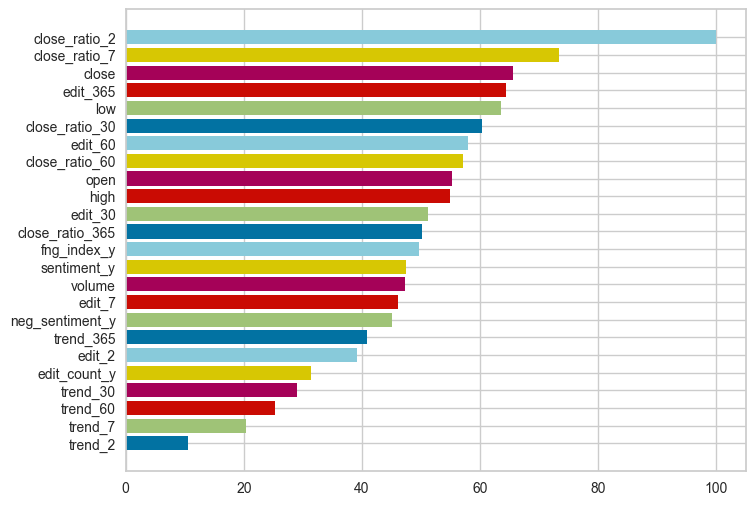

In [227]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_rf_cr, 
                                              X=X_train, 
                                              y=y_train,
                                              label=predictors)
plt.show(feature_importance)

##### Random Forest (RF) Scaled

In [198]:
best_score, best_params, best_model_rf_sca = run_grid_search_cv(model=rf_model, params=rf_params, X=X_train_scaled, y=y_train)
print_grid_evaluation_report(best_score, best_params)

----Evaluation Report----

Best Score Achieved: 0.4535

Best Params Found: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}

---------------------------------



In [204]:
predictions = backtest(new_data, best_model_rf_sca, predictors, mode='sca')

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

Precisão do modelo: 0.58
Acurácia do modelo: 0.54
            target  predictions
2021-03-05       0            0
2021-03-06       1            0
2021-03-07       1            0
2021-03-08       1            0
2021-03-09       1            0
...            ...          ...
2024-09-03       1            0
2024-09-04       0            0
2024-09-05       0            1
2024-09-06       1            0
2024-09-07       1            1

[1283 rows x 2 columns]


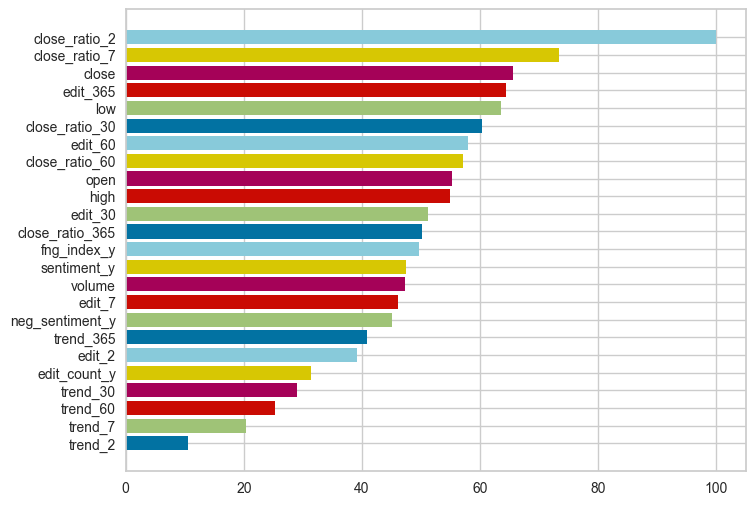

In [233]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_rf_sca, 
                                              X=X_train_scaled, 
                                              y=y_train, 
                                              label = predictors)
plt.show(feature_importance)

##### Random Forest (RF) Normalized

In [201]:
best_score, best_params, best_model_rf_norm = run_grid_search_cv(model=rf_model, params=rf_params, X=X_train_norm, y=y_train)
print_grid_evaluation_report(best_score, best_params)

----Evaluation Report----

Best Score Achieved: 0.5165000000000001

Best Params Found: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 150}

---------------------------------



In [205]:
predictions = backtest(new_data, best_model_rf_norm, predictors, mode='norm')

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

Precisão do modelo: 0.37
Acurácia do modelo: 0.50
            target  predictions
2021-03-05       0            0
2021-03-06       1            0
2021-03-07       1            0
2021-03-08       1            0
2021-03-09       1            0
...            ...          ...
2024-09-03       1            0
2024-09-04       0            0
2024-09-05       0            0
2024-09-06       1            0
2024-09-07       1            0

[1283 rows x 2 columns]


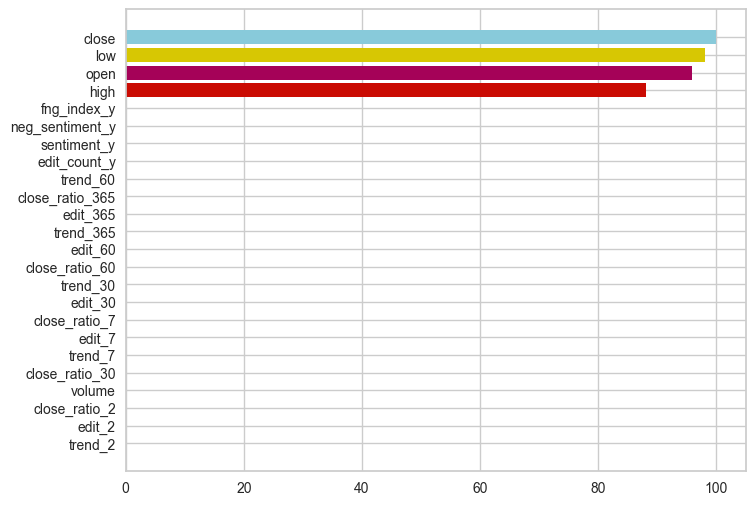

In [234]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_rf_norm, 
                                              X=X_train_norm, 
                                              y=y_train, 
                                              label = predictors)
plt.show(feature_importance)

#### KNN Classifier

In [207]:
knn_params = {
    'n_neighbors':[5,7,9,10,11,12,13,14, 30, 60],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
}
knn_model = KNeighborsClassifier()

##### KNN Classifier Raw

In [208]:
best_score, best_params, best_model_knn_cr = run_grid_search_cv(model=knn_model, params=knn_params, X=X_train, y=y_train)
print_grid_evaluation_report(best_score, best_params)

----Evaluation Report----

Best Score Achieved: 0.5185000000000001

Best Params Found: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}

---------------------------------



In [209]:
predictions = backtest(new_data, best_model_knn_cr, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

Precisão do modelo: 0.53
Acurácia do modelo: 0.53
            target  predictions
2021-03-05       0            1
2021-03-06       1            0
2021-03-07       1            1
2021-03-08       1            0
2021-03-09       1            1
...            ...          ...
2024-09-03       1            0
2024-09-04       0            1
2024-09-05       0            0
2024-09-06       1            1
2024-09-07       1            0

[1283 rows x 2 columns]


##### KNN Classifier Scaled

In [210]:
best_score, best_params, best_model_knn_sca = run_grid_search_cv(model=knn_model, params=knn_params, X=X_train_scaled, y=y_train)
print_grid_evaluation_report(best_score, best_params)

----Evaluation Report----

Best Score Achieved: 0.469

Best Params Found: {'algorithm': 'auto', 'n_neighbors': 13, 'weights': 'uniform'}

---------------------------------



In [211]:
predictions = backtest(new_data, best_model_knn_sca, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

Precisão do modelo: 0.51
Acurácia do modelo: 0.51
            target  predictions
2021-03-05       0            1
2021-03-06       1            0
2021-03-07       1            0
2021-03-08       1            1
2021-03-09       1            1
...            ...          ...
2024-09-03       1            0
2024-09-04       0            0
2024-09-05       0            0
2024-09-06       1            1
2024-09-07       1            1

[1283 rows x 2 columns]


##### KNN Classifier Normalized

In [212]:
best_score, best_params, best_model_knn_norm = run_grid_search_cv(model=knn_model, params=knn_params, X=X_train_norm, y=y_train)
print_grid_evaluation_report(best_score, best_params)

----Evaluation Report----

Best Score Achieved: 0.5135000000000001

Best Params Found: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'uniform'}

---------------------------------



In [213]:
predictions = backtest(new_data, best_model_knn_norm, predictors, mode='norm')

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

Precisão do modelo: 0.50
Acurácia do modelo: 0.51
            target  predictions
2021-03-05       0            0
2021-03-06       1            0
2021-03-07       1            1
2021-03-08       1            0
2021-03-09       1            0
...            ...          ...
2024-09-03       1            1
2024-09-04       0            1
2024-09-05       0            1
2024-09-06       1            1
2024-09-07       1            1

[1283 rows x 2 columns]


#### XGBoost

In [216]:
xgb_params = {'random_state' : [1], 
              'learning_rate' : [0.1, 0.2, 0.3, 0.4], 
              'n_estimators' : [100,150,200,250,300], 
              'colsample_bytree' : [0.25, 0.5, 0.75, 1], 
              'max_depth' : [3,5,6,7,8]
}

model_xgb = XGBClassifier()

##### XGBoost Raw

In [217]:
best_score, best_params, best_model_xgb_cr = run_grid_search_cv(model=model_xgb, params=xgb_params, X=X_train, y=y_train)
print_grid_evaluation_report(best_score, best_params)

----Evaluation Report----

Best Score Achieved: 0.4715

Best Params Found: {'colsample_bytree': 0.75, 'learning_rate': 0.4, 'max_depth': 6, 'n_estimators': 150, 'random_state': 1}

---------------------------------



c:\Users\julio\OneDrive\Área de Trabalho\Projects\bitcoin_trend_prediction\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [218]:
predictions = backtest(new_data, best_model_xgb_cr, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

Precisão do modelo: 0.51
Acurácia do modelo: 0.52
            target  predictions
2021-03-05       0            1
2021-03-06       1            0
2021-03-07       1            0
2021-03-08       1            0
2021-03-09       1            0
...            ...          ...
2024-09-03       1            1
2024-09-04       0            0
2024-09-05       0            1
2024-09-06       1            1
2024-09-07       1            1

[1283 rows x 2 columns]


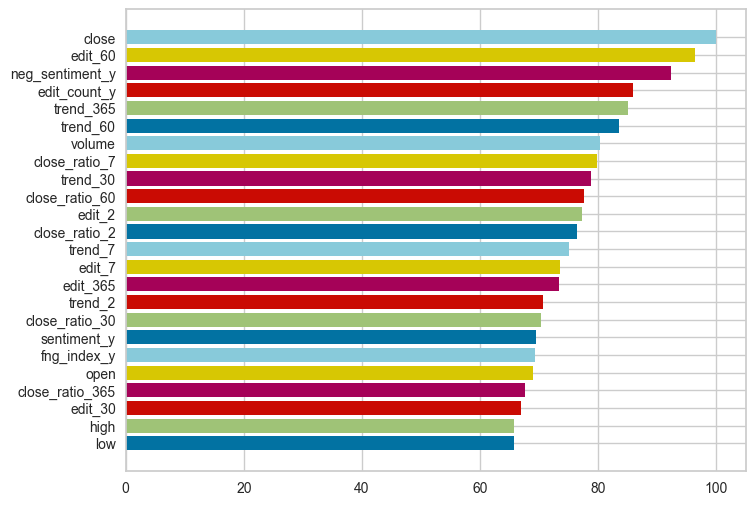

In [236]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_xgb_cr, 
                                              X=X_train, 
                                              y=y_train,
                                              label=predictors)
plt.show(feature_importance)

##### XGBoost Scaled

In [219]:
best_score, best_params, best_model_xgb_sca = run_grid_search_cv(model=model_xgb, params=xgb_params, X=X_train_scaled, y=y_train)
print_grid_evaluation_report(best_score, best_params)

----Evaluation Report----

Best Score Achieved: 0.4715

Best Params Found: {'colsample_bytree': 0.75, 'learning_rate': 0.4, 'max_depth': 6, 'n_estimators': 150, 'random_state': 1}

---------------------------------



c:\Users\julio\OneDrive\Área de Trabalho\Projects\bitcoin_trend_prediction\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [220]:
predictions = backtest(new_data, best_model_xgb_sca, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

Precisão do modelo: 0.51
Acurácia do modelo: 0.52
            target  predictions
2021-03-05       0            1
2021-03-06       1            0
2021-03-07       1            0
2021-03-08       1            0
2021-03-09       1            0
...            ...          ...
2024-09-03       1            1
2024-09-04       0            0
2024-09-05       0            1
2024-09-06       1            1
2024-09-07       1            1

[1283 rows x 2 columns]


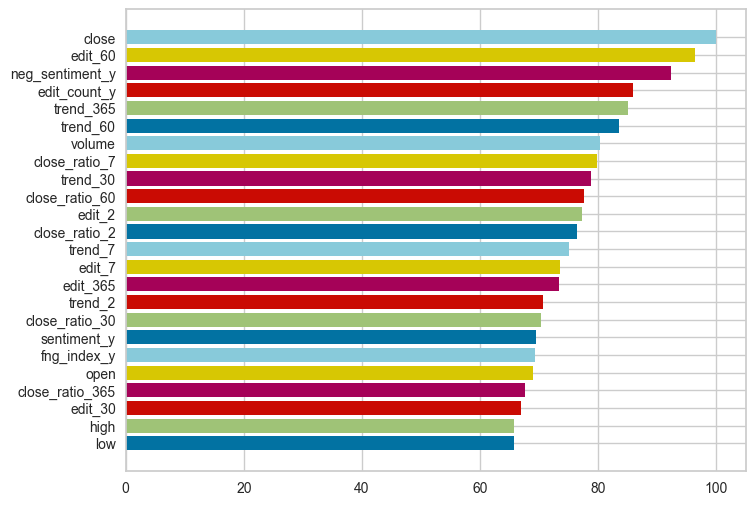

In [237]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_xgb_sca, 
                                              X=X_train_scaled, 
                                              y=y_train,
                                              label=predictors)
plt.show(feature_importance)

##### XGBoost Norm

In [221]:
best_score, best_params, best_model_xgb_norm = run_grid_search_cv(model=model_xgb, params=xgb_params, X=X_train_norm, y=y_train)
print_grid_evaluation_report(best_score, best_params)

----Evaluation Report----

Best Score Achieved: 0.4835

Best Params Found: {'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300, 'random_state': 1}

---------------------------------



In [222]:
predictions = backtest(new_data, best_model_xgb_norm, predictors)

# Avaliar o modelo
precision, accuracy = evaluate_model(predictions)
print(f"Precisão do modelo: {precision:.2f}")
print(f"Acurácia do modelo: {accuracy:.2f}")
print(predictions)

Precisão do modelo: 0.50
Acurácia do modelo: 0.51
            target  predictions
2021-03-05       0            1
2021-03-06       1            1
2021-03-07       1            0
2021-03-08       1            0
2021-03-09       1            0
...            ...          ...
2024-09-03       1            1
2024-09-04       0            0
2024-09-05       0            1
2024-09-06       1            1
2024-09-07       1            1

[1283 rows x 2 columns]


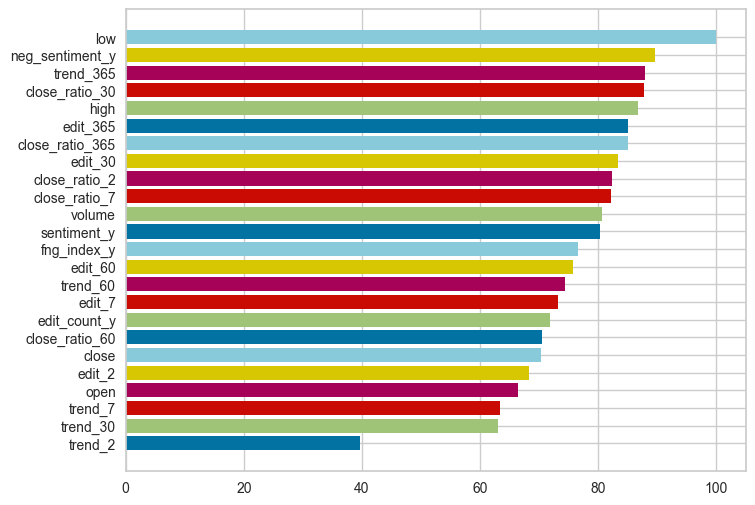

In [238]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importance = plot_feature_importances(model=best_model_xgb_norm, 
                                              X=X_train_norm, 
                                              y=y_train,
                                              label=predictors)
plt.show(feature_importance)

### Running Best Model

In [25]:
# # Função de predição
# def predict(train: pd.DataFrame, test: pd.DataFrame, predictors: List[str], model: XGBClassifier) -> pd.DataFrame:
#     model.fit(train[predictors], train["target"])
#     preds = model.predict(test[predictors])
#     preds = pd.Series(preds, index=test.index, name="predictions")
#     return pd.concat([test["target"], preds], axis=1)

# # Função de backtesting
# # Usaremos uma abordagem de janela móvel para fazer o backtesting do modelo.
# # Pegaremos uma janela de dados, usaremos para treinar o modelo e, em seguida, usaremos o modelo para prever a próxima janela de dados.
# # Repetiremos esse processo até termos usado todos os dados.
# # O parâmetro start significa 3 anos de dados para treinar o modelo.
# # O parâmetro step significa 150 dias de dados para testar o modelo.
# def backtest(data: pd.DataFrame, model: XGBClassifier, predictors: List[str], start: int = 1095, step: int = 150) -> pd.DataFrame:
#     all_predictions = []

#     for i in range(start, data.shape[0], step):
#         train = data.iloc[0:i].copy()
#         test = data.iloc[i:(i + step)].copy()
#         predictions = predict(train, test, predictors, model)
#         all_predictions.append(predictions)

#     return pd.concat(all_predictions)

# # Função de avaliação do modelo
# def evaluate_model(predictions: pd.DataFrame) -> Tuple[float, float]:
#     precision = precision_score(predictions["target"], predictions["predictions"])
#     accuracy = accuracy_score(predictions["target"], predictions["predictions"])
#     return precision, accuracy

In [35]:
# # Criar e treinar o modelo XGBoost
# model = XGBClassifier(random_state=1, learning_rate=0.2, n_estimators=500, colsample_bytree = 1, max_depth = 8)
# predictions = backtest(data, model, predictors)

# # Avaliar o modelo
# precision, accuracy = evaluate_model(predictions)
# print(f"Precisão do modelo: {precision:.2f}")
# print(f"Acurácia do modelo: {accuracy:.2f}")
# print(predictions)

Precisão do modelo: 0.48
Acurácia do modelo: 0.49
            target  predictions
2021-03-05       0            0
2021-03-06       1            0
2021-03-07       1            0
2021-03-08       1            0
2021-03-09       1            0
...            ...          ...
2024-09-02       0            0
2024-09-03       1            1
2024-09-04       0            1
2024-09-05       0            1
2024-09-06       1            0

[1282 rows x 2 columns]


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2378 entries, 2018-03-02 to 2024-09-06
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   open                         2378 non-null   float64
 1   high                         2378 non-null   float64
 2   low                          2378 non-null   float64
 3   close                        2378 non-null   float64
 4   volume                       2378 non-null   int64  
 5   edit_count                   2378 non-null   float64
 6   tomorrow                     2377 non-null   float64
 7   sentiment                    2378 non-null   float64
 8   neg_sentiment                2378 non-null   float64
 9   fng_index                    2378 non-null   int64  
 10  target                       2378 non-null   int64  
 11  fng_classification_adjusted  2378 non-null   int64  
dtypes: float64(8), int64(4)
memory usage: 241.5+ KB


### Serialização do Modelo

In [239]:
# Salvar o modelo treinado em um arquivo
model_filename = "btc_trend_prediction_model_best.joblib"
dump(best_model_rf_sca, model_filename)

['btc_trend_prediction_model_best.joblib']